In [1]:
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
import faiss

# 1. Load CLIP Model & Processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. Load Metadata and Image Embeddings
products_df = pd.read_csv("C:/Users/chira/Desktop/Fashion Visual Search & Intelligent Styling Assistant/embedding/valid_products.csv")
embeddings = np.load("C:/Users/chira/Desktop/Fashion Visual Search & Intelligent Styling Assistant/embedding/fashion_image_embeddings.npy")


c:\Users\chira\Desktop\Fashion Visual Search & Intelligent Styling Assistant\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
# 3. Normalize embeddings for cosine similarity
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# 4. Create FAISS index with cosine similarity
index = faiss.IndexFlatIP(normalized_embeddings.shape[1])  # IP = Inner Product
index.add(normalized_embeddings)


In [3]:
# 5. Get embedding for a new image
def get_image_embedding(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        with torch.no_grad():
            features = model.get_image_features(**inputs)
        features = features / features.norm(dim=-1, keepdim=True)
        return features.cpu().numpy()[0]
    except Exception as e:
        print(f"❌ Error fetching image: {e}")
        return None

# 6. Search similar products
def search_similar(image_url, top_k=5, exact_threshold=0.05):
    query_embed = get_image_embedding(image_url)
    if query_embed is None:
        return None

    # Normalize and reshape for FAISS
    query_embed = query_embed / np.linalg.norm(query_embed)
    query_embed = np.expand_dims(query_embed, axis=0)

    distances, indices = index.search(query_embed, top_k)

    results = products_df.iloc[indices[0]].copy()
    results["distance"] = distances[0]
    results["exact_match"] = results["distance"] >= (1 - exact_threshold)  # cosine similarity close to 1
    return results[["pdp_images_s3", "category_type", "image_url", "distance", "exact_match"]]


# Test1

In [4]:
# 7. Example usage:
image_url = "https://gallery.stylumia.com/originals/2020/05/48/6360245240b68885bd4dbcef8d8856c0fb13f1314769f5273904a6eac26fb452_1.jpg"  # Replace with your query image
similar_items = search_similar(image_url, top_k=5)

if similar_items is not None:
    print(similar_items)
else:
    print("Failed to retrieve similar items.")

similar_items.to_csv("similar_products_output.csv", index=False)
print("✅ Saved top similar items to similar_products_output.csv")

                                           pdp_images_s3 category_type  \
3      ['https://gallery.stylumia.com/originals/2020/...         dress   
7485   ['https://gallery.stylumia.com/originals/2024/...         dress   
159    ['https://gallery.stylumia.com/originals/2023/...         dress   
534    ['https://gallery.stylumia.com/originals/2023/...         dress   
11864  ['https://gallery.stylumia.com/originals/2025/...         dress   

                                               image_url  distance  \
3      https://gallery.stylumia.com/originals/2020/05...  1.000000   
7485   https://gallery.stylumia.com/originals/2024/11...  0.942881   
159    https://gallery.stylumia.com/originals/2023/01...  0.941817   
534    https://gallery.stylumia.com/originals/2023/09...  0.936313   
11864  https://gallery.stylumia.com/originals/2025/04...  0.933905   

       exact_match  
3             True  
7485         False  
159          False  
534          False  
11864        False  
✅ Saved 

# Test2

In [ ]:
# 7. Example usage:
image_url = "https://gallery.stylumia.com/originals/2025/02/7/e1ad71d26176ce1628493ea7e9d1f42458ca64418cfa134c1ae7f1452063418e.jpg"  # Replace with your query image
similar_items = search_similar(image_url, top_k=5)

if similar_items is not None:
    print(similar_items)
else:
    print("Failed to retrieve similar items.")

similar_items.to_csv("similar_products_output.csv", index=False)
print("✅ Saved top similar items to similar_products_output.csv")

                                           pdp_images_s3 category_type  \
15800  ['https://gallery.stylumia.com/originals/2024/...         jeans   
16442  ['https://gallery.stylumia.com/originals/2024/...         jeans   
15441  ['https://gallery.stylumia.com/originals/2024/...         jeans   
14593  ['https://gallery.stylumia.com/originals/2022/...         jeans   
16895  ['https://gallery.stylumia.com/originals/2025/...         jeans   

                                               image_url  distance  \
15800  https://gallery.stylumia.com/originals/2024/10...  0.951952   
16442  https://gallery.stylumia.com/originals/2024/12...  0.938153   
15441  https://gallery.stylumia.com/originals/2024/08...  0.936441   
14593  https://gallery.stylumia.com/originals/2022/11...  0.934237   
16895  https://gallery.stylumia.com/originals/2025/02...  0.929615   

       exact_match  
15800         True  
16442        False  
15441        False  
14593        False  
16895        False  
✅ Saved 

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def display_similar_results(query_image_url, results_df, top_k=5):
    """
    Display the query image and top-k similar results in a horizontal layout.
    """
    plt.figure(figsize=(15, 5))

    # Display query image
    ax = plt.subplot(1, top_k + 1, 1)
    try:
        response = requests.get(query_image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        plt.imshow(img)
        ax.set_title("Query Image", fontsize=10)
        plt.axis("off")
    except:
        print("Failed to load query image.")

    # Display top-k similar results
    for i in range(top_k):
        ax = plt.subplot(1, top_k + 1, i + 2)
        try:
            image_url = results_df.iloc[i]['image_url']
            distance = results_df.iloc[i]['distance']
            category = results_df.iloc[i]['category_type']

            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            plt.imshow(img)
            ax.set_title(f"{category}\nDist: {distance:.2f}", fontsize=9)
            plt.axis("off")
        except:
            print(f"Failed to load result image {i + 1}")

    plt.tight_layout()
    plt.show()


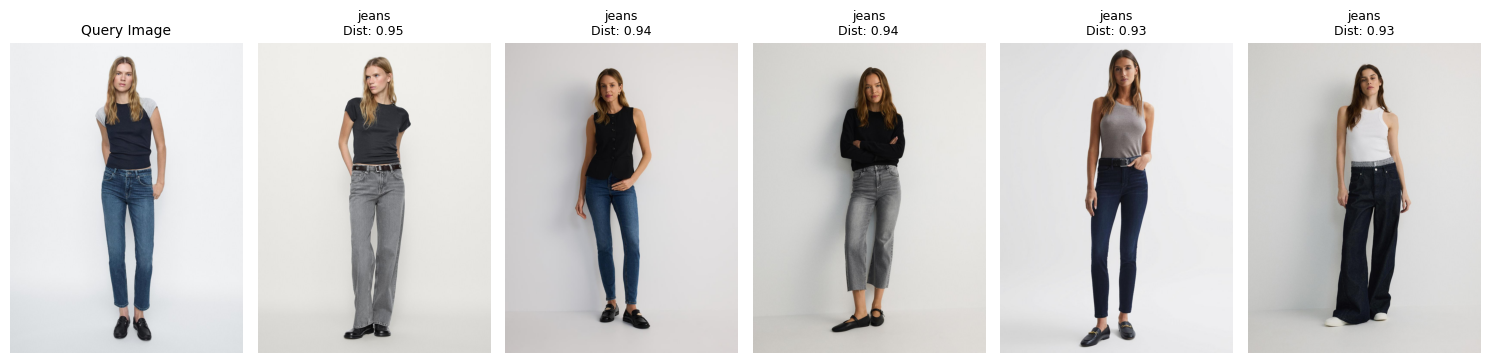

In [12]:
image_url = "https://gallery.stylumia.com/originals/2025/02/7/e1ad71d26176ce1628493ea7e9d1f42458ca64418cfa134c1ae7f1452063418e.jpg"
similar_items = search_similar(image_url, top_k=10)

if similar_items is not None:
    display_similar_results(image_url, similar_items, top_k=5)
else:
    print("Failed to retrieve similar items.")


